In [4]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from sklearn.utils import shuffle
from torchsample.modules import ModuleTrainer

%matplotlib inline

In [5]:
#path = "data/ml-20m/"
path = "data/ml-latest-small/"
model_path = 'data/lesson-4-models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64
use_cuda=False

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [6]:
ratings = pd.read_csv(path+'ratings.csv')
# ratings = shuffle(ratings)
ratings.tail()

,userId,movieId,rating,timestamp
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663
100003,671,6565,3.5,1074784724


In [7]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [77]:
movies_table = pd.read_csv(path+'movies.csv').set_index('movieId')
movies_table.tail()

,title,genres
movieId,,
162672,Mohenjo Daro (2016),Adventure|Drama|Romance
163056,Shin Godzilla (2016),Action|Adventure|Fantasy|Sci-Fi
163949,The Beatles: Eight Days a Week - The Touring Y...,Documentary
164977,The Gay Desperado (1936),Comedy
164979,"Women of '69, Unboxed",Documentary


We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [9]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

This is the number of latent factors in each embedding.

In [10]:
num_dimensions = 50
num_users = ratings.userId.nunique()
num_movies = ratings.movieId.nunique()
num_users, num_movies

(671, 9066)

Randomly split into training and validation.

In [11]:
mask = np.random.rand(len(ratings)) < 0.8
ratings_train = ratings[mask]
ratings_valid = ratings[~mask]

## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [48]:
import torch.nn as nn
import torch.nn.functional as F

class UserMovieModule(nn.Module):
    def __init__(self, num_users, num_movies, num_dimensions):
        super(UserMovieModule, self).__init__()
        self.users_embedding = nn.Embedding(num_users, num_dimensions)
        self.movies_embedding = nn.Embedding(num_movies, num_dimensions)
        self.user_bias = nn.Embedding(num_users, 1)
        self.movie_bias = nn.Embedding(num_movies, 1)
        self.init()

    def forward(self, users, movies):
        u = self.users_embedding(users)
        m = self.movies_embedding(movies)
        dot_product = torch.sum(torch.mul(u, m), dim=1)
        return dot_product
    
    def init(self):
        torch.nn.init.uniform(self.users_embedding.weight, a=-0.05, b=0.05)
        torch.nn.init.uniform(self.movies_embedding.weight, a=-0.05, b=0.05)

def tensorl(from_int):
    return torch.from_numpy(np.array(from_int)).long()

def tensorf(from_int):
    return torch.from_numpy(np.array(from_int)).float()

In [49]:
criterion = nn.MSELoss()
model = UserMovieModule(num_users, num_movies, num_dimensions)
if(use_cuda):
    model.cuda()
    criterion.cuda()
trainer = ModuleTrainer(model)

In [50]:
if 1 == 1:
    trainer.set_optimizer(optim.Adam, lr=1e-3)
    trainer.set_loss(criterion)
    trainer.fit([tensorl(ratings_train.userId), tensorl(ratings_train.movieId)], tensorf(ratings_train.rating), 
                batch_size=batch_size,
                val_data=([tensorl(ratings_valid.userId), tensorl(ratings_valid.movieId)], tensorf(ratings_valid.rating)),
                nb_epoch=5, shuffle=True)
    trainer.save_state_dict(model_path + '/model-no-bias.pth')
    
model.load_state_dict(torch.load(model_path + '/model-no-bias.pth'))

Epoch 1/5: 1257 batches [00:09, 137.32 batches/s, loss=10.6672, val_loss=4.1231]   
Epoch 2/5: 1257 batches [00:14, 85.19 batches/s, loss=2.3918, val_loss=1.8040]   
Epoch 3/5: 1257 batches [00:14, 85.42 batches/s, loss=1.2616, val_loss=1.4188]   
Epoch 4/5: 1257 batches [00:14, 85.60 batches/s, loss=0.9516, val_loss=1.2882]   
Epoch 5/5: 1257 batches [00:14, 85.00 batches/s, loss=0.8015, val_loss=1.2280]   


The best benchmarks are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [65]:
import torch.nn as nn
import torch.nn.functional as F

class UserMovieModuleWithBias(nn.Module):
    def __init__(self, num_users, num_movies, num_dimensions):
        super(UserMovieModuleWithBias, self).__init__()
        self.users_embedding = nn.Embedding(num_users, num_dimensions)
        self.movies_embedding = nn.Embedding(num_movies, num_dimensions)
        self.user_bias = nn.Embedding(num_users, 1)
        self.movie_bias = nn.Embedding(num_movies, 1)
        self.init()

    def forward(self, users, movies):
        u = self.users_embedding(users)
        bu = self.user_bias(users)
        m = self.movies_embedding(movies)
        bm = self.movie_bias(users)
        dot_product = torch.sum(torch.mul(u, m), dim=1)
        result = torch.add(dot_product, bu).add_(bm)
        return result
    
    def init(self):
        torch.nn.init.uniform(self.users_embedding.weight, a=-0.05, b=0.05)
        torch.nn.init.uniform(self.movies_embedding.weight, a=-0.05, b=0.05)
        torch.nn.init.uniform(self.user_bias.weight, a=-0.05, b=0.05)
        torch.nn.init.uniform(self.movie_bias.weight, a=-0.05, b=0.05)

In [71]:
criterion = nn.MSELoss()
model = UserMovieModuleWithBias(num_users, num_movies, num_dimensions)
if(use_cuda):
    model.cuda()
    criterion.cuda()
trainer = ModuleTrainer(model)

In [72]:
from torchsample.regularizers import L2Regularizer

if 1 == 1:
    trainer.set_optimizer(optim.Adam, lr=1e-2)
    trainer.set_loss(criterion)

    regularizers = [L2Regularizer(scale=1e-2, module_filter='*embedding*')]
    trainer.set_regularizers(regularizers)
    
    trainer.fit([tensorl(ratings_train.userId), tensorl(ratings_train.movieId)], tensorf(ratings_train.rating), 
                batch_size=batch_size,
                val_data=([tensorl(ratings_valid.userId), tensorl(ratings_valid.movieId)], tensorf(ratings_valid.rating)),
                nb_epoch=10, shuffle=True)
    trainer.save_state_dict(model_path + '/model-bias.pth')
    
model.load_state_dict(torch.load(model_path + '/model-bias.pth'))

Epoch 1/10: 1257 batches [00:54, 23.08 batches/s, loss=3.1330, regularizer_loss=0.5818, val_loss=1.0212]   
Epoch 2/10: 1257 batches [01:02, 20.12 batches/s, loss=1.3774, regularizer_loss=0.5209, val_loss=0.8616]   
Epoch 3/10: 1257 batches [01:03, 19.74 batches/s, loss=1.1836, regularizer_loss=0.4428, val_loss=0.8459]   
Epoch 4/10: 1257 batches [01:01, 18.21 batches/s, loss=1.1640, regularizer_loss=0.4509, val_loss=0.8417]   
Epoch 5/10: 1257 batches [00:58, 21.34 batches/s, loss=1.1606, regularizer_loss=0.4581, val_loss=0.8424]   
Epoch 6/10: 1257 batches [00:59, 17.37 batches/s, loss=1.1437, regularizer_loss=0.4593, val_loss=0.8446]   
Epoch 7/10: 1257 batches [01:16, 16.46 batches/s, loss=1.1364, regularizer_loss=0.4596, val_loss=0.8369]   
Epoch 8/10: 1257 batches [01:34, 13.37 batches/s, loss=1.1233, regularizer_loss=0.4580, val_loss=0.8383]   
Epoch 9/10: 1257 batches [01:06, 18.97 batches/s, loss=1.1191, regularizer_loss=0.4561, val_loss=0.8348]   
Epoch 10/10: 1257 batches [0

In [73]:
if 1 == 1:
    trainer.set_optimizer(optim.Adam, lr=1e-3)
    trainer.fit([tensorl(ratings_train.userId), tensorl(ratings_train.movieId)], tensorf(ratings_train.rating), 
                    batch_size=batch_size,
                    val_data=([tensorl(ratings_valid.userId), tensorl(ratings_valid.movieId)], tensorf(ratings_valid.rating)),
                    nb_epoch=3, shuffle=True)

Epoch 1/3: 1257 batches [01:00, 20.66 batches/s, loss=0.8232, regularizer_loss=0.2177, val_loss=0.7970]   
Epoch 2/3: 1257 batches [01:00, 20.73 batches/s, loss=0.7299, regularizer_loss=0.1918, val_loss=0.7859]   
Epoch 3/3: 1257 batches [01:00, 18.39 batches/s, loss=0.6926, regularizer_loss=0.2069, val_loss=0.7816]   


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [74]:
trainer.predict([tensorl([3]), tensorl([6])])

Variable containing:
 4.8061
[torch.FloatTensor of size 1x1]

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [75]:
g=ratings.groupby('movieId')['rating'].count()
top_movies=g.sort_values(ascending=False)[:2000]
top_movies = torch.LongTensor(np.array(top_movies.index))
top_movies[:5]


  57
  49
  99
  92
 143
[torch.LongTensor of size 5]

First, we'll look at the movie bias term. We create a 'model' - which in PyTorch is simply using the movie_bias field from our model. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [78]:
movie_bias = model.movie_bias(Variable(top_movies, volatile=True))
movie_names = movies_table['title'].to_dict()
movie_ratings = [(b[0].data.cpu()[0], movie_names[movies[i]]) for i,b in zip(top_movies, movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [81]:
from operator import itemgetter
sorted(movie_ratings, key=itemgetter(0), reverse=False)[:15]

[(-0.04999130964279175, 'Waiting to Exhale (1995)'),
 (-0.04998200759291649, 'Blind Side, The  (2009)'),
 (-0.04995981603860855, 'Man with the Golden Gun, The (1974)'),
 (-0.04994472116231918, "Dude, Where's My Car? (2000)"),
 (-0.04993141442537308, 'Goofy Movie, A (1995)'),
 (-0.04991568624973297, 'Third Man, The (1949)'),
 (-0.049872223287820816, 'Around the World in 80 Days (1956)'),
 (-0.04981032758951187, 'Daredevil (2003)'),
 (-0.04971112683415413, 'Men of Honor (2000)'),
 (-0.04927796497941017, 'Nick of Time (1995)'),
 (-0.049206413328647614, 'Wonder Boys (2000)'),
 (-0.04917401075363159, 'King Kong (1976)'),
 (-0.048940181732177734, 'Caddyshack (1980)'),
 (-0.048712506890296936, 'Godzilla (1998)'),
 (-0.04865460470318794, 'Wild Wild West (1999)')]

In [82]:
from operator import itemgetter
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(2.5032389163970947, 'Legends of the Fall (1994)'),
 (2.4570648670196533, 'Mirror Has Two Faces, The (1996)'),
 (2.4322450160980225, 'Jungle Book, The (1994)'),
 (2.405385732650757, 'Total Recall (1990)'),
 (2.378448247909546, 'Fear and Loathing in Las Vegas (1998)'),
 (2.281982898712158, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)'),
 (2.2691853046417236, 'Raising Arizona (1987)'),
 (2.2672295570373535, 'Disclosure (1994)'),
 (2.2521917819976807, 'Big (1988)'),
 (2.241617441177368, 'Casino (1995)'),
 (2.23540997505188, 'Hairspray (1988)'),
 (2.2340199947357178,
  "Monty Python's And Now for Something Completely Different (1971)"),
 (2.2314419746398926, 'Fly, The (1958)'),
 (2.2290546894073486, 'Aladdin (1992)'),
 (2.2106122970581055, 'Bone Collector, The (1999)')]

We can now do the same thing for the embeddings.

In [84]:
movies_embedding = model.movies_embedding(Variable(top_movies, volatile=True))
movies_embedding.size()

torch.Size([2000, 50])

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [85]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movies_pca = pca.fit(movies_embedding.data.cpu().numpy().T).components_

In [86]:
fac0 = movies_pca[0]
fac0

array([-0.04307693, -0.06649297, -0.07918579, ..., -0.00661842,
        0.0160651 ,  0.00609351])

In [88]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, top_movies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [89]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.081087442052062739, 'Battlefield Earth (2000)'),
 (0.076402307396108593, 'Speed 2: Cruise Control (1997)'),
 (0.071550997683035925, 'Batman & Robin (1997)'),
 (0.068964269471725403, 'Flintstones, The (1994)'),
 (0.068805214561170489, 'Anaconda (1997)'),
 (0.067166091319384252, 'Congo (1995)'),
 (0.066669380292356861, 'Wild Wild West (1999)'),
 (0.062400966418928873, 'Batman Forever (1995)'),
 (0.061999663458749195, 'Judge Dredd (1995)'),
 (0.059574785266585474, 'Striptease (1996)')]

In [90]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.085105568569933454, 'Godfather, The (1972)'),
 (-0.079185794238934376, 'Shawshank Redemption, The (1994)'),
 (-0.068356316723929667, 'Usual Suspects, The (1995)'),
 (-0.068292083617868857, 'Godfather: Part II, The (1974)'),
 (-0.066492966422796576, 'Pulp Fiction (1994)'),
 (-0.066486089413128863, "Schindler's List (1993)"),
 (-0.063891933190106137, 'Casablanca (1942)'),
 (-0.062387024292047039, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.060760076923112728,
  "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (-0.060460652212634212, 'Fargo (1996)')]

In [92]:
fac1 = movies_pca[1]

In [93]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, top_movies)]

The 2nd is 'hollywood blockbuster'.

In [94]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.117079259900425, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.11470397638518001, 'Lord of the Rings: The Two Towers, The (2002)'),
 (0.11209180913538738, 'Shrek (2001)'),
 (0.10945122645567616,
  'Lord of the Rings: The Return of the King, The (2003)'),
 (0.10603134813111496, 'Braveheart (1995)'),
 (0.098468450292102924,
  'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.094519137682999341, 'Jurassic Park (1993)'),
 (0.093921821931929952, 'Titanic (1997)'),
 (0.087909107211966278, 'X-Men (2000)'),
 (0.087062187403512376, 'Shrek 2 (2004)')]

In [95]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.072908343983229318, 'Royal Tenenbaums, The (2001)'),
 (-0.071330970118711617, 'Clockwork Orange, A (1971)'),
 (-0.068484435106144076, 'Taxi Driver (1976)'),
 (-0.067698741522599679, 'Annie Hall (1977)'),
 (-0.059576879844364584, 'Mulholland Drive (2001)'),
 (-0.05762246527767239, 'Leaving Las Vegas (1995)'),
 (-0.056248755994983121, 'Reservoir Dogs (1992)'),
 (-0.054307587626447315, 'Big Lebowski, The (1998)'),
 (-0.052210128851320731, 'American Psycho (2000)'),
 (-0.050850257636553695, 'Island of Dr. Moreau, The (1996)')]

In [97]:
fac2 = movies_pca[2]

The 3rd is 'violent vs happy'.

In [98]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, top_movies)]

In [99]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.1045831422783056, 'Napoleon Dynamite (2004)'),
 (0.090851112895748418, 'While You Were Sleeping (1995)'),
 (0.084702289765171634, 'Babe (1995)'),
 (0.084350225250651181, 'Star Wars: Episode II - Attack of the Clones (2002)'),
 (0.074048518053904763, 'Four Weddings and a Funeral (1994)'),
 (0.071563305191773327, 'Twister (1996)'),
 (0.070946108605455235, 'Perfect Storm, The (2000)'),
 (0.070195847526201754, 'Sleepless in Seattle (1993)'),
 (0.068504816710736188, "Schindler's List (1993)"),
 (0.068249257005016925, "Romy and Michele's High School Reunion (1997)")]

In [100]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.094514880562114711, 'Fight Club (1999)'),
 (-0.094051757014773488, 'American Psycho (2000)'),
 (-0.092880567242161607,
  'Léon: The Professional (a.k.a. The Professional) (Léon) (1994)'),
 (-0.091837364211015404, 'From Dusk Till Dawn (1996)'),
 (-0.083097582299821671, 'Starship Troopers (1997)'),
 (-0.08151110406830929, 'Matrix, The (1999)'),
 (-0.07838480475365539, 'X-Men (2000)'),
 (-0.077987460004422804, 'Army of Darkness (1993)'),
 (-0.073671304935473816, 'Guardians of the Galaxy (2014)'),
 (-0.07066425188794842, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

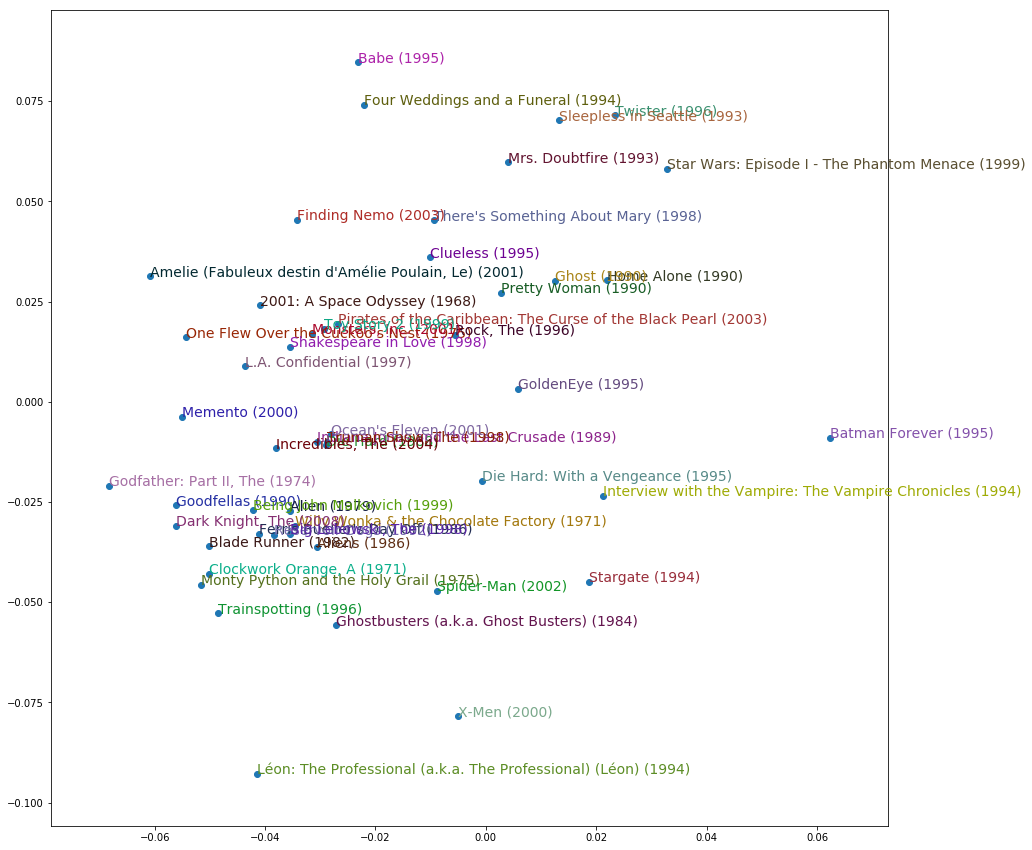

In [102]:
from matplotlib import pyplot as plt

start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [113]:
class UserMovieModuleNN(nn.Module):
    def __init__(self, num_users, num_movies, num_dimensions):
        super().__init__()
        self.users_embedding = nn.Embedding(num_users, num_dimensions)
        self.movies_embedding = nn.Embedding(num_movies, num_dimensions)
        self.predictor = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(2 * num_dimensions, 70),
            nn.ReLU(True),
            nn.Dropout(0.75),
            nn.Linear(70, 1),
        )

    def forward(self, users, movies):
        u = self.users_embedding(users)
        m = self.movies_embedding(movies)
        
        x = torch.cat([u, m], 1)
        r = self.predictor(x)
        return r
    
    def init(self):
        torch.nn.init.uniform(self.users_embedding.weight, a=-0.05, b=0.05)
        torch.nn.init.uniform(self.movies_embedding.weight, a=-0.05, b=0.05)
        torch.nn.init.xavier_uniform(self.predictor[1].weight) # Linear 1
        torch.nn.init.constant(self.predictor[1].bias, val=0.0) # Linear 1
        torch.nn.init.xavier_uniform(self.predictor[3].weight) # Linear 2
        torch.nn.init.constant(self.predictor[3].bias, val=0.0) # Linear 2

In [132]:
model_nn = UserMovieModuleNN(num_users, num_movies, num_dimensions)
if(use_cuda):
    model_nn.cuda()
trainer_nn = ModuleTrainer(model)

In [133]:
trainer_nn.set_optimizer(optim.Adam, lr=1e-2)
trainer_nn.set_loss(criterion)

regularizers = [L2Regularizer(scale=1e-2, module_filter='*embedding*')]
trainer_nn.set_regularizers(regularizers)

trainer_nn.fit([tensorl(ratings_train.userId), tensorl(ratings_train.movieId)], tensorf(ratings_train.rating), 
                batch_size=batch_size,
                val_data=([tensorl(ratings_valid.userId), tensorl(ratings_valid.movieId)], tensorf(ratings_valid.rating)),
                nb_epoch=1, shuffle=True)

Epoch 1/1: 1257 batches [00:56, 22.14 batches/s, loss=1.1347, regularizer_loss=0.3168, val_loss=0.8216]   


In [134]:
trainer_nn.set_optimizer(optim.Adam, lr=1e-3)
trainer_nn.fit([tensorl(ratings_train.userId), tensorl(ratings_train.movieId)], tensorf(ratings_train.rating), 
                batch_size=batch_size,
                val_data=([tensorl(ratings_valid.userId), tensorl(ratings_valid.movieId)], tensorf(ratings_valid.rating)),
                nb_epoch=4, shuffle=True)

Epoch 1/4: 1257 batches [01:01, 17.46 batches/s, loss=0.8356, regularizer_loss=0.1641, val_loss=0.7972]   
Epoch 2/4: 1257 batches [01:01, 20.37 batches/s, loss=0.7552, regularizer_loss=0.1531, val_loss=0.7847]   
Epoch 3/4: 1257 batches [01:01, 20.45 batches/s, loss=0.7154, regularizer_loss=0.1740, val_loss=0.7793]   
Epoch 4/4: 1257 batches [01:01, 17.77 batches/s, loss=0.6885, regularizer_loss=0.1980, val_loss=0.7770]   


This improves on our already impressive accuracy even further!